In [1]:
#import necesssary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, validation_curve
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from pylab import savefig

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [2]:
np.random.seed(500)

In [3]:
tweet_df = pd.read_csv('/Users/kusalkasilva/Documents/Twitter Research Project/final notebooks/TrainingHashtag.csv')
tweet_df[['tweet', 'crime', 'Category', 'lemmatized_tweet', 'stemming_tweet']].head(2)

,tweet,crime,Category,lemmatized_tweet,stemming_tweet
0,- she was returning to her hostel when she was...,Yes,1,"['return', 'hostel', 'savagely', 'beat', 'unco...","['return', 'hostel', 'savag', 'beaten', 'uncon..."
1,BBC News - Napier Barracks: Fire at Covid-hit ...,Yes,1,"['bbc', 'news', 'napier', 'barrack', 'fire', '...","['bbc', 'news', 'napier', 'barrack', 'fire', '..."


In [4]:
#train_test split
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(tweet_df['lemmatized_tweet'],
                                                                    tweet_df['Category'], 
                                                                    stratify=tweet_df['Category'], 
                                                                    test_size=0.2,
                                                                   random_state = 42)

In [5]:
#TF-IDF - Lemmatized tweets
Tfidf_vect_lem = TfidfVectorizer()
Tfidf_vect_lem.fit(tweet_df['lemmatized_tweet'])
X_train_lem_Tfidf = Tfidf_vect_lem.transform(X_train_lem)
X_test_lem_Tfidf = Tfidf_vect_lem.transform(X_test_lem)

In [6]:
def evaluation_measures(y_test, pred_model, name): #(test_set, ML model, "lem" or "stem")
    
    #confusion matrix
    conf_marix = confusion_matrix(y_test, pred_model)
    
    #calculations
    TP = conf_marix[1][1] #True Positives
    FP = conf_marix[0][1] #False Positives
    FN = conf_marix[1][0] #False Negatives
    TN = conf_marix[0][0] #True Negatives
    Specificity = TN/(TN+FP)
    Error_rate = (FP+FN)/(TP+TN+FP+FN)
    FPR, TPR, _ = metrics.roc_curve(y_test, pred_model)
    AUC = metrics.roc_auc_score(y_test,pred_model)
    
    #printing measures
    print('Accuracy - ', accuracy_score(y_test, pred_model))
    print('Precision - ', precision_score(y_test, pred_model))
    print('Recall/Sensitivity - ', recall_score(y_test, pred_model))
    print('F1-Score - ', f1_score(y_test, pred_model))
    print('Specificity - ', Specificity)
    print('Error rate - ', Error_rate)
    print('AUC - ', AUC) 
    
    
    #create ROC curve
    plt.plot(FPR, TPR, label="AUC = " +str(AUC))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.savefig('ROC Curve ' + str(name) + '.png') #saving plot
    plt.show()
    
    
    #Confusion Matrix
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos'] #name of each box in confusion matrix grid
    counts = ["{0:0.0f}".format(value) for value in conf_marix.flatten()] #TN, FP, FN, TP values
    percentage = ["{0:.2%}".format(value) for value in conf_marix.flatten()/np.sum(conf_marix)] #calculating %
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names, counts, percentage)]
    labels = np.asarray(labels).reshape(2,2)
    c_matrix = sns.heatmap(conf_marix, annot=labels, fmt='', cmap='Blues')
    figure = c_matrix.get_figure()
    figure.savefig('CMatrix ' + str(name) + '.png') #saving confusion matrix
    

In [7]:
# fit the training dataset on the classifier
SVM_lem_tune = svm.SVC(C=10, degree = 1, gamma=1, kernel='rbf')
t3 = time.time()
SVM_lem_tune.fit(X_train_lem_Tfidf,y_train_lem)
# predict the labels on validation dataset
predictions_SVM_lem_tune = SVM_lem_tune.predict(X_test_lem_Tfidf)
f_t3 = time.time()-t3
print(classification_report(y_test_lem, predictions_SVM_lem_tune))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       134
           1       0.89      0.87      0.88       134

    accuracy                           0.88       268
   macro avg       0.88      0.88      0.88       268
weighted avg       0.88      0.88      0.88       268



------------- PERFORMANCE SVM AFTER TUNING - LEMMATIZED -------------

Training time -> 0.18203210830688477  seconds 

Accuracy -  0.8805970149253731
Precision -  0.8923076923076924
Recall/Sensitivity -  0.8656716417910447
F1-Score -  0.8787878787878788
Specificity -  0.8955223880597015
Error rate -  0.11940298507462686
AUC -  0.8805970149253731


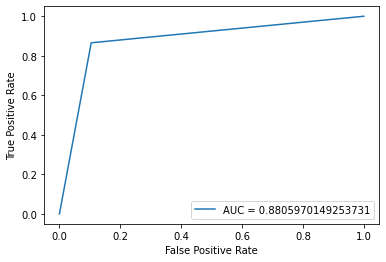

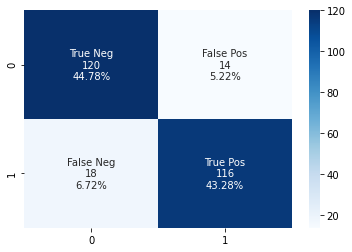

In [8]:
print("------------- PERFORMANCE SVM AFTER TUNING - LEMMATIZED -------------\n")
print("Training time ->", f_t3, " seconds \n")
evaluation_measures(y_test_lem, predictions_SVM_lem_tune, 'svm_Lem_tuning')

In [9]:
#Predicting based on the trained model

df = pd.read_csv("/Users/kusalkasilva/Documents/Twitter Research Project/final notebooks/Preprocessed_Dataset.csv")
tweet = df['lemmatized_tweet']
tf_idf = Tfidf_vect_lem.transform(tweet)
# Predict on `X_unseen`
prediction = SVM_lem_tune.predict(tf_idf)
df["Prediction"] = prediction

In [10]:
df.groupby('Prediction').describe()

index                                                        \
               count           mean           std   min      25%       50%   
Prediction                                                                   
0           206667.0  122461.410003  71378.574507   0.0  60444.5  122345.0   
1            24793.0  125321.883677  69392.108493  14.0  67391.0  123565.0   

                               author id                ...                \
                 75%       max     count          mean  ...           75%   
Prediction                                              ...                 
0           184118.5  247006.0  206667.0  2.694752e+17  ...  7.034463e+17   
1           186362.0  247004.0   24793.0  2.797681e+17  ...  7.264432e+17   

                                id                                            \
                     max     count          mean           std           min   
Prediction                                                                     
0           1.475477e+18  206667.0  1.405441e+18  3.859662e+16  1.344797e+18   
1           1.475477e+18   24793.0  1.406940e+18  3.786926e+16  1.344797e+18   

                                                                    
                     25%           50%           75%           max  
Prediction                                                          
0           1.371303e+18  1.402263e+18  1.440422e+18  1.476704e+18  
1           1.372935e+18  1.402567e+18  1.441805e+18  1.476687e+18  

[2 rows x 24 columns]

In [11]:
df.to_csv("/Users/kusalkasilva/Documents/Twitter Research Project/final notebooks/SVMPredict_WholeDataset.csv", index=False)